In [8]:
library(monocle3)
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(SCORPIUS)
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(scales)

In [3]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [12]:
integrated_meta = read.table(paste(out, "integrated_annotations.txt", sep = ""))

In [270]:
f = paste(out, "obj.integrated.frazer.melton", sep = "")
load(f, verbose = T)

Loading objects:
  integrated


In [271]:
integrated = integrated

In [272]:
Idents(integrated) <- "integrated_snn_res.0.05"

In [273]:
integrated@meta.data$major_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "major_cell_population"] 
integrated@meta.data$minor_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "minor_cell_population"] 

In [274]:
integrated@meta.data$study = "Frazer"
integrated@meta.data[integrated@meta.data$orig.ident == "x1", ]$study = "Melton"

# Figure 2A

In [117]:
PlotUMAP <- function(obj, annotate, lX, lY, text_width, n.col, plot_leg = FALSE, cols2use = NULL){

    options(repr.plot.width = 3, repr.plot.height = 3)
    par(mar = c(4, 4, 1, 1), xpd=FALSE)
    umap = as.data.frame(Embeddings(obj[["umap"]]))
    umap$clusters = obj@meta.data[match(rownames(umap), rownames(obj@meta.data)), annotate]
    
    qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
    col_vector    = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
    my_color_palette <- hue_pal()(length(unique(umap$clusters)))
    
    if(length(cols2use) > 0){colrs = data.frame(clusters = unique(umap$clusters), color = cols2use)}
    else{colrs = data.frame(clusters = sort(unique(umap$clusters)), color = my_color_palette)}
    umap$color = colrs[match(umap$clusters, colrs$clusters), "color"]
    

    
    plot(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = umap$color,
         cex = .1,
         las = 1)

    if( plot_leg == TRUE){
        legend(lX, lY,
               legend = colrs$clusters,
               col    = colrs$color,
               pch    = rep(16, nrow(colrs)),
               cex=.9,
               bg="transparent",
               box.lty = 0,
               y.intersp = 1.75,
               ncol = n.col,
               x.intersp = 1.15,
               text.width = text_width)
    }
    
    return(colrs)
    
}

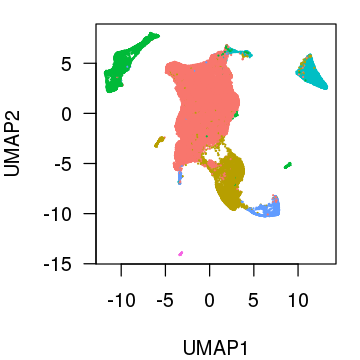

In [74]:
x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)

In [237]:
integrated
x = as.data.frame(table(integrated@meta.data$integrated_snn_res.0.05))
x$frac = (x$Freq / sum(x$Freq)) *100
x

An object of class Seurat 
60358 features across 112509 samples within 2 assays 
Active assay: RNA (58358 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

Var1,Freq,frac
<fct>,<int>,<dbl>
0,74303,66.041828
1,15457,13.738456
2,9664,8.589535
3,9135,8.119350
4,3599,3.198855
5,351,0.311975


# Figure 2B

In [276]:
cols = data.frame(celltype = sort(unique(integrated@meta.data$major_cell_population)), col = c("#56ccd8", "#9c0031", "#4bb047", "#c3826c", "#a6cee3", "#5ebd53", "#d984c6", "#ff7f00", "#67c2a5", "#b2e18c",
                                                                                               "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80", "#e5191b", "#984ea4", "#387cb7", "#f69c9c"))
# colsrowadd = data.frame(celltype = NA, col =)
# cols = rbind(cols, colsrowadd)

In [275]:
unique(integrated@meta.data$Assigned_cluster)

[1] NA                 "repl"             "pdx1"             "nkx61"           
 [5] "sc_alpha"         "fev_high_isl_neg" "neurog3"          "sst_hhex"        
 [9] "exo"              "sc_beta"          "sc_ec"            "foxj1"

In [277]:
colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c7", colsUSE)

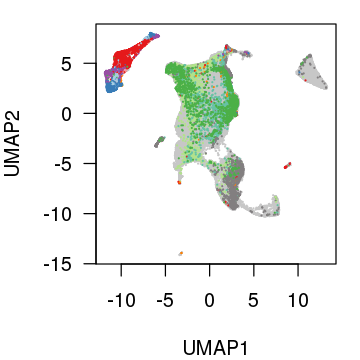

In [175]:
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2C

In [285]:
PlotFractionCellsStudy <- function(){

    options(repr.plot.width = 8, repr.plot.height = 6)
    
    par(mfrow = c(2, 1), mar = c(4, 5, 1, 1))
    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$study))
    data = data[c(2, 1), ]
    barplot(data, col = c("#2c6954", "#84d9be"), las = 1, ylab = "N cells", xlab = "Cluster", , ylim = c(0, 80000))

    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$Assigned_cluster))
    barplot(data, col = cols[cols$celltype %in% sort(unique(integrated@meta.data$Assigned_cluster)), "col"], las = 1, ylab = "N cells", xlab = "Cluster", ylim = c(0, 12000))
}

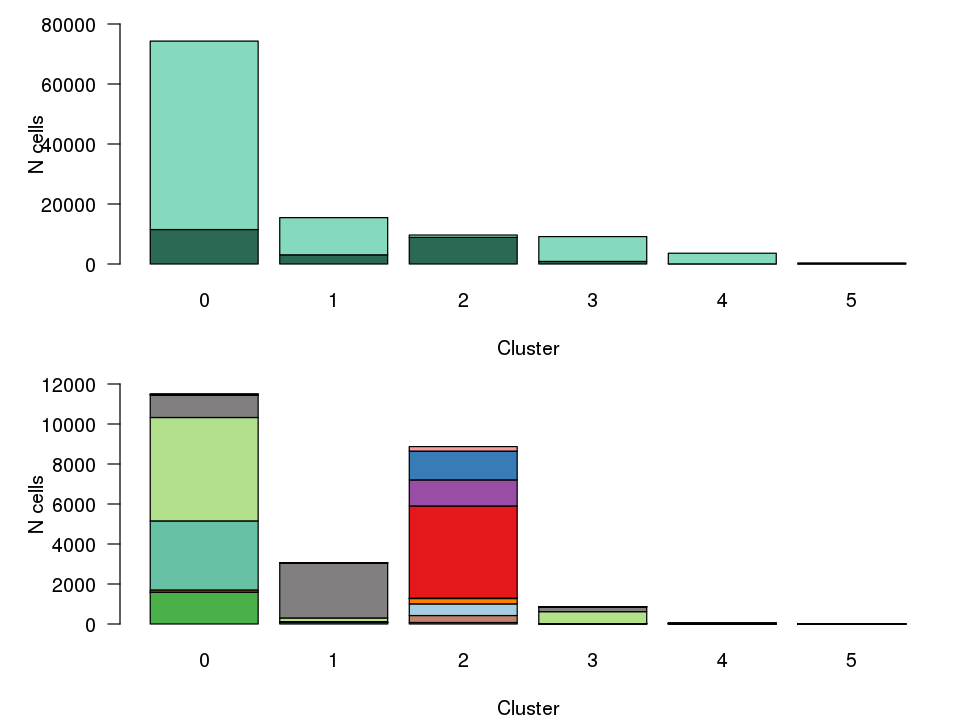

In [286]:
PlotFractionCellsStudy()

# Figure 2D

In [411]:
PlotGeneExpression <- function(obj){
    options(repr.plot.width = 3, repr.plot.height = 2.5)
    p <- FeaturePlot(obj, features = c("POU5F1", "PDX1", "NKX6-1", "CHGA", "INS", "PLVAP", "TOP2A", "COL3A1"),
                pt.size = .0001, min.cutoff = c(0, 0, 0, 1, 1, 1, 0, 0), max.cutoff = c(1.5, 1.5, 1.5, 50, 50, 2, 3, 1),
                combine = FALSE, cols = c("#c2c2c210","#910000"))

    for(i in 1:length(p)) {

        p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 4) + NoAxes()

    }

    cowplot::plot_grid(plotlist = p, ncol = 4)
}


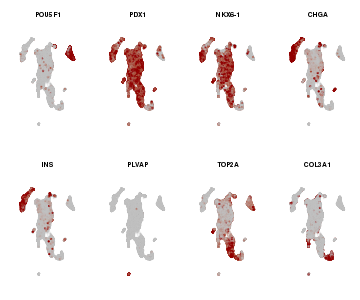

In [412]:
PlotGeneExpression(integrated)

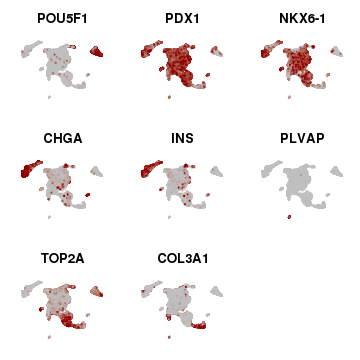

In [294]:
PlotGeneExpression(integrated)

# Figure 2E

In [234]:
pseudotime_meta = read.table(paste(out, "integrated_cluster0_pseudotime.txt", sep = ""))

In [257]:
integrated@meta.data$pseudotime      = as.numeric(pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "pseudotime"])
integrated@meta.data$pseudotime_bins = pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "quants"] 

In [296]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster0_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C0_test


In [318]:
load(paste(out, "obj.integrated.frazer.melton_cluster0_pseudotime", sep = ""))

In [316]:
colsUSE = cols[cols$celltype %in% (unique(integrated.C0_test@meta.data$Assigned_cluster)), "col" ][c(5, 6, 4, 3, 7, 1, 9, 8, 2)]
colsUSE = c( "#c7c7c7", colsUSE)

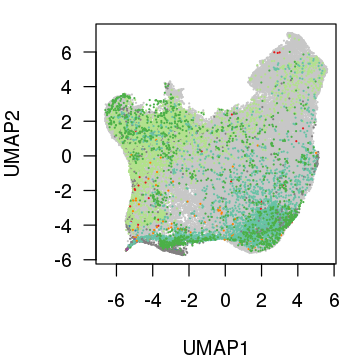

In [317]:
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

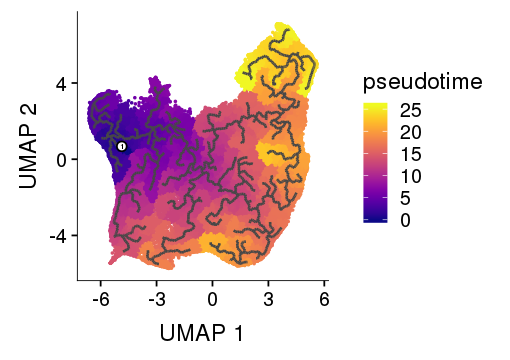

In [358]:
options(repr.plot.width = 4.25, repr.plot.height = 3)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

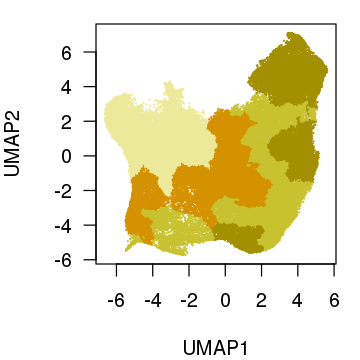

In [332]:
x = PlotUMAP(integrated.C0_test, "pseudotime_quantile", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = c("#d49100","#c9c230",
                                                                                                                     "#ede99a", "#a39000"))

In [338]:
# bin time by quantiles
pseudotime_ppc = as.data.frame(pseudotime(cds))
colnames(pseudotime_ppc) = "pseudotime"
quants = as.data.frame(quantile(pseudotime_ppc$pseudotime))

pseudotime_ppc$quants = NA
pseudotime_ppc$pseudotime = as.numeric(pseudotime_ppc$pseudotime)

pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[1, 1] & pseudotime_ppc$pseudotime <= quants[2, 1],  "quants" ] = "PPC_1"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[2, 1] & pseudotime_ppc$pseudotime <= quants[3, 1],  "quants" ] = "PPC_2"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[3, 1] & pseudotime_ppc$pseudotime <= quants[4, 1],  "quants" ] = "PPC_3"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[4, 1] & pseudotime_ppc$pseudotime <= quants[5, 1],  "quants" ] = "PPC_4"


pData(cds)$pseudotime_quantile = pseudotime_ppc[match(rownames(pData(cds)), rownames(pseudotime_ppc)), "quants"]

In [351]:
genes = c("PDX1", "NKX6-1")

genes2plot = cds[rowData(cds)$gene_short_name %in% genes,]

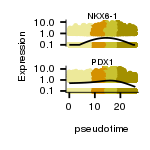

In [372]:
options(repr.plot.width = 1.25, repr.plot.height = 1.25)
plot_genes_in_pseudotime(genes2plot,color_cells_by="pseudotime_quantile", min_expr=0.1) +
    scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))

# Figure 2F

In [380]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster1_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C1


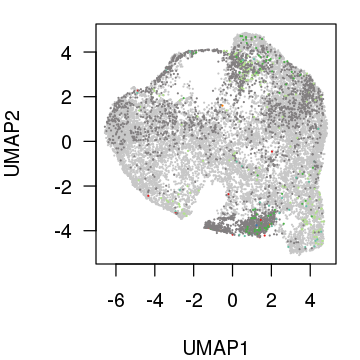

In [400]:
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2G

In [379]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster2_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C2


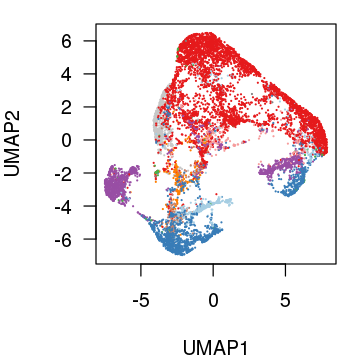

In [404]:
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2H

In [287]:
colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c700", colsUSE)

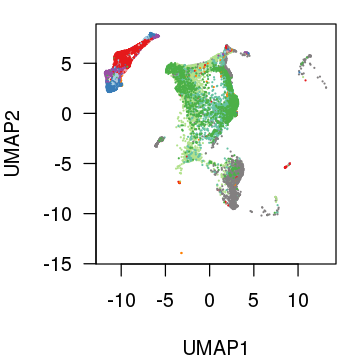

In [288]:
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Output

In [291]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCluster.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)
dev.off()

colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c7", colsUSE)
png(paste(out, "UMAP_byMeltonCelltype.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

pdf(paste(out, "Overall_Barplot.pdf"), width = 8, height = 6)
PlotFractionCellsStudy()
dev.off()

png(paste(out, "UMAP_expression.png"), width = 4, height = 2, units = "in", res = 1200)
PlotGeneExpression(integrated)
dev.off()

png 
  2

In [375]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster0_lenged.png"), width = 10, height = 10, units = "in", res = 1200)
plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups=FALSE, label_leaves=FALSE, label_branch_points=FALSE, graph_label_size=1.5)
dev.off()

png(paste(out, "UMAP_byPseudotimeBin_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "pseudotime_quantile", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = c("#d49100","#c9c230","#ede99a", "#a39000"))
dev.off()

png(paste(out, "Expression_over_pseudotime_legend.png"), width = 1.25, height = 1.25, units = "in", res = 1200)

plot_genes_in_pseudotime(genes2plot,color_cells_by="pseudotime_quantile", min_expr=0.1) +
    scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))
dev.off()

png 
  2

In [406]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster1.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster2.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()


png 
  2

png 
  2

# OLD

In [7]:
frazer_meta = read.csv("../Table/frazer_barcodes_meta.csv")

In [30]:
integrated@meta.data$Frazer_cluster_0.1 = NA
integrated@meta.data[match(frazer_meta$X, integrated@meta.data$cell), "Frazer_cluster_0.1"] = frazer_meta[match(frazer_meta$X, integrated@meta.data$cell), "RNA_snn_res.0.1"]

In [19]:
integrated@meta.data$celltype_melton = str_split_fixed(integrated@meta.data$melton_celltype, "_x", 2)[,1]

In [21]:
integrated@meta.data$Celltype = integrated@meta.data$celltype_melton

In [40]:
integrated@meta.data[integrated@meta.data$Celltype == "NA_NA", "Celltype"] = integrated@meta.data[integrated@meta.data$Celltype == "NA_NA", "Frazer_cluster_0.1"]

# Reannotate Melton Celltypes to make more interpretable

In [43]:
integrated@meta.data$new_celltype = integrated@meta.data$Celltype

In [46]:
integrated@meta.data[integrated@meta.data$Celltype == "repl",]$new_celltype             = "ESC-Replicating"
integrated@meta.data[integrated@meta.data$Celltype == "pdx1",]$new_celltype             = "ESC-PDX1_progenitor"
integrated@meta.data[integrated@meta.data$Celltype == "nkx61",]$new_celltype            = #"ESC-NKX6-1_progenitor"
integrated@meta.data[integrated@meta.data$Celltype == "sc_alpha",]$new_celltype         = #"ESC-A"
integrated@meta.data[integrated@meta.data$Celltype == "fev_high_isl_neg",]$new_celltype = #"ESC_FEV_high_ISL_low_partial_endrocrine_enduction"
integrated@meta.data[integrated@meta.data$Celltype == "neurog3",]$new_celltype          = #"ESC-NEUROG_progenitor_endocrine_induction"
integrated@meta.data[integrated@meta.data$Celltype == "sst_hhex",]$new_celltype         = #"ESC_Delta"
integrated@meta.data[integrated@meta.data$Celltype == "exo",]$new_celltype              = "ESC-non-endocrine"
integrated@meta.data[integrated@meta.data$Celltype == "sc_beta",]$new_celltype          = #"ESC-B"
integrated@meta.data[integrated@meta.data$Celltype == "sc_ec",]$new_celltype            = #"ESC-EC"
integrated@meta.data[integrated@meta.data$Celltype == "foxj1",]$new_celltype            = #"ESC-CHGA_FOXJ1_pos"

In [80]:
integrated@meta.data[is.na(integrated@meta.data$Stage), "Stage" ] <- "Frazer_PPC"

In [66]:
integrated@meta.data$orig_dataset = integrated@meta.data$orig.ident

integrated@meta.data[ integrated@meta.data$orig_dataset == "x1", "orig_dataset"] = "Melton_ESC"
integrated@meta.data[ integrated@meta.data$orig_dataset == "Frazermerged_new", "orig_dataset"] = "Frazer_PPC"

table(integrated@meta.data$orig_dataset)


Frazer_PPC Melton_ESC 
     84654      24321 

# Visualize clustering

In [48]:
par(mar = c(10, 5, 1, 1))
my_color_palette <- hue_pal()(5)

In [100]:
PlotUMAP <- function(obj, annotate, lX, lY, text_width, n.col, plot_leg = FALSE){

    options(repr.plot.width = 3, repr.plot.height = 3)
    par(mar = c(4, 4, 1, 1), xpd=FALSE)
    umap = as.data.frame(Embeddings(obj[["umap"]]))
    umap$clusters = obj@meta.data[match(rownames(umap), rownames(obj@meta.data)), annotate]
    
    qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
    col_vector    = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
    my_color_palette <- hue_pal()(length(unique(umap$clusters)))
    
    if(length(unique(umap$clusters)) > 8){colrs = data.frame(clusters = unique(umap$clusters), color = col_vector[1:length(unique(umap$clusters))])}
    else{colrs = data.frame(clusters = sort(unique(umap$clusters)), color = my_color_palette)}
    umap$color = colrs[match(umap$clusters, colrs$clusters), "color"]
    
    plot(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = umap$color,
         cex = .1,
         las = 1)

    if( plot_leg == TRUE){
        legend(lX, lY,
               legend = colrs$clusters,
               col    = colrs$color,
               pch    = rep(16, nrow(colrs)),
               cex=.9,
               bg="transparent",
               box.lty = 0,
               y.intersp = 1.75,
               ncol = n.col,
               x.intersp = 1.15,
               text.width = text_width)
    }
    
}

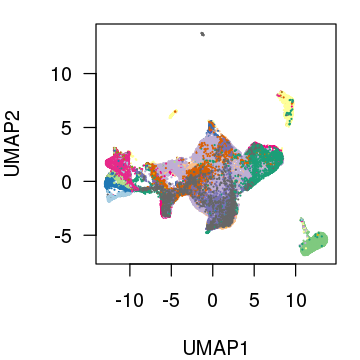

In [58]:
PlotUMAP(integrated, "new_celltype", 7, 16, text_width = 2, n.col = 2, plot_leg = F)

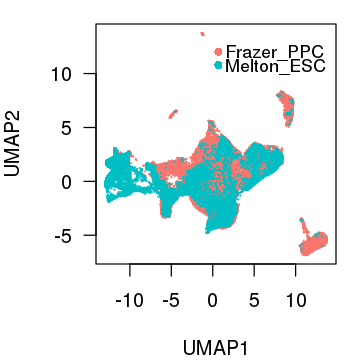

In [72]:
PlotUMAP(integrated, "orig_dataset", 0, 13, text_width = 2, n.col = 1, plot_leg = T)

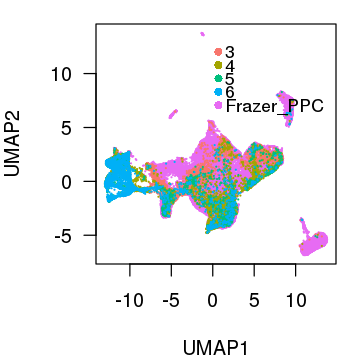

In [83]:
PlotUMAP(integrated, "Stage", 0, 13, text_width = 2, n.col = 1, plot_leg = T)

# Breakdown UMAPs

In [140]:
BreakPlotUMAP <- function(obj, annotate, lX, lY, text_width, n.col, plot_leg = FALSE, temp.cols){

    obj = integrated

#     options(repr.plot.width = 3, repr.plot.height = 3)
    par(mar = c(4, 4, 1, 1), xpd=FALSE)
    umap = as.data.frame(Embeddings(obj[["umap"]]))
    umap$clusters = obj@meta.data[match(rownames(umap), rownames(obj@meta.data)), annotate]

    temp.cols = temp.cols[1:length(unique(umap$clusters))]

    colrs = data.frame(clusters = sort(unique(umap$clusters)), color = temp.cols)

    umap$color = colrs[match(umap$clusters, colrs$clusters), "color"]
    
    
#     plot(coords[, "UMAP_1"], coords[, "UMAP_2"], col = "#d4d4d4", pch = 19, cex = .3, xaxt='n', yaxt='n', bty="n", xlab = "", ylab = "")
#     points(coords.temp, col = densCols(coords.temp, colramp = colorRampPalette(c(samp.cols.min[i], samp.cols.max[i]))), pch = 19, cex = .05)
    
    
    plot(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = "#ededed20", #rep(, nrow(umap)),
         cex = .1,
         las = 1)

    points(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = umap$color,
         cex = .1,
         las = 1)

    
    
    if( plot_leg == TRUE){
        legend(lX, lY,
               legend = colrs$clusters,
               col    = colrs$color,
               pch    = rep(16, nrow(colrs)),
               cex=.9,
               bg="transparent",
               box.lty = 0,
               y.intersp = 1.75,
               ncol = n.col,
               x.intersp = 1.15,
               text.width = text_width)
    }
    
}

In [141]:
BreakUMAPWrapper <- function(obj, annotate, samp.cols, samp.cols.null){

    for( i in seq(0, (length(samp.cols)) - 1)){

        if(i < length(unique(obj@meta.data[, annotate]))){
            x = i + 1
            temp.cols = samp.cols.null
            temp.cols[x] = samp.cols[x]
            BreakPlotUMAP(obj, annotate, 0, 13, text_width = 2, n.col = 1, plot_leg = T, temp.cols)
        }


    }
}

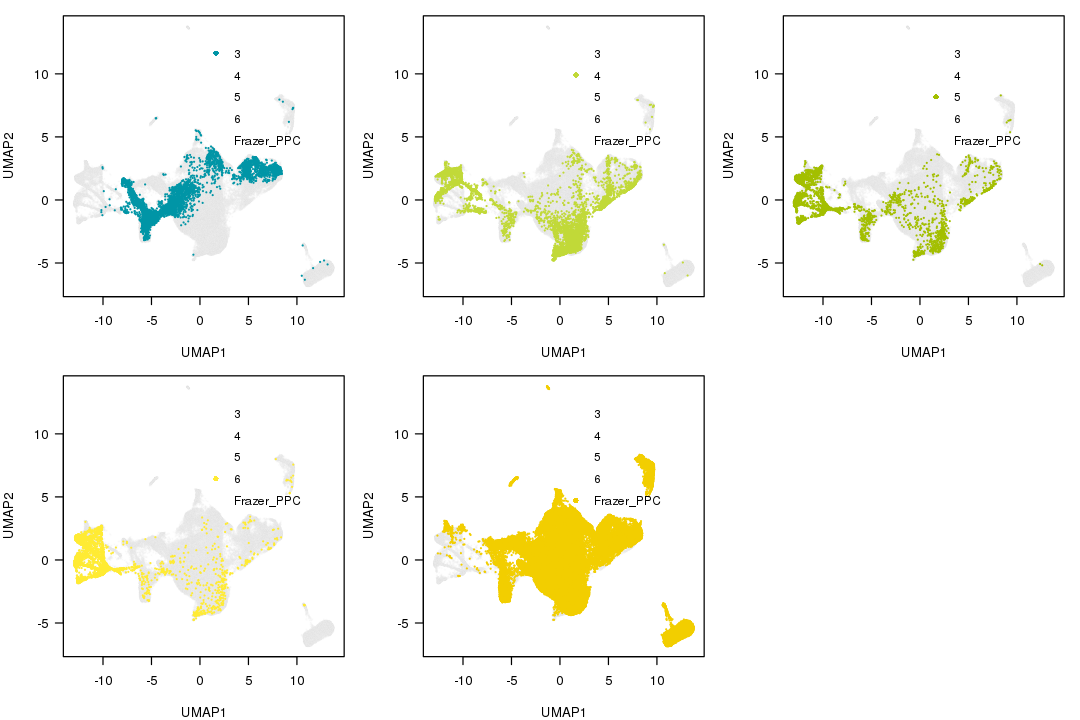

In [142]:
par(mfrow = c(2,3))
options(repr.plot.width = 9, repr.plot.height = 6)
samp.cols      = c("#0095a6","#c1d938", "#a3bf00", "#ffeb33", "#f2ce00", "#ebb454", "#bf7c0a", "#c46c3d", "#b34a12")
samp.cols.null = c("#ededed00", "#ededed00", "#ededed00", "#ededed00", "#ededed00", "#ededed00","#ededed00", "#ededed00", "#ededed00")

BreakUMAPWrapper(integrated, "Stage", samp.cols, samp.cols.null)

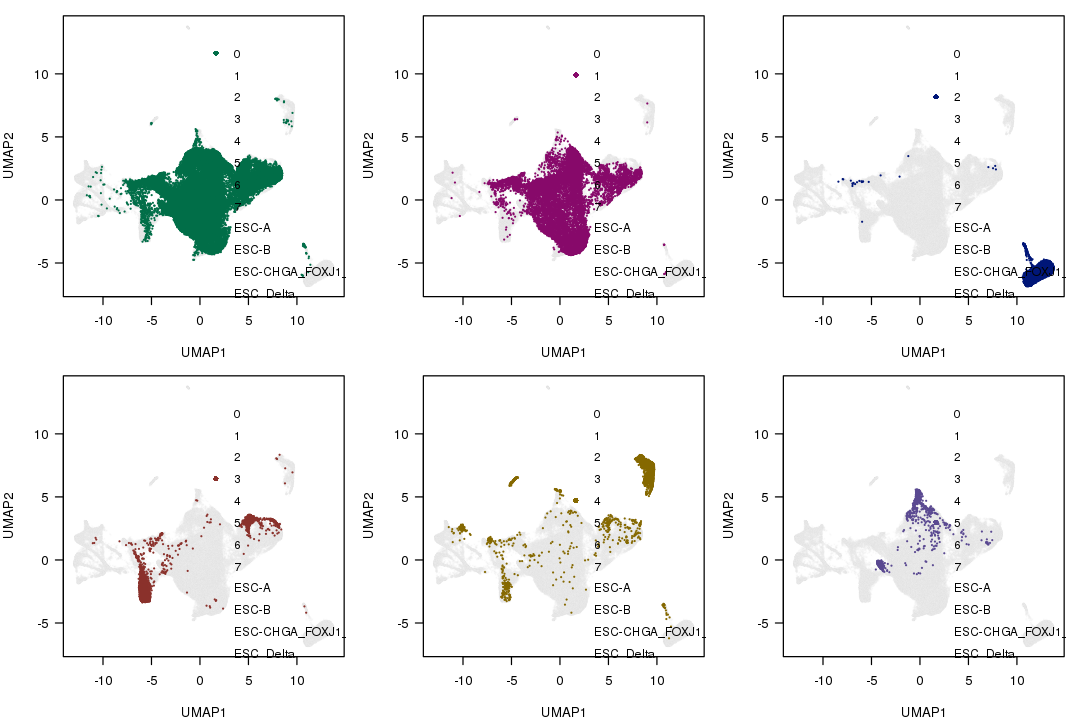

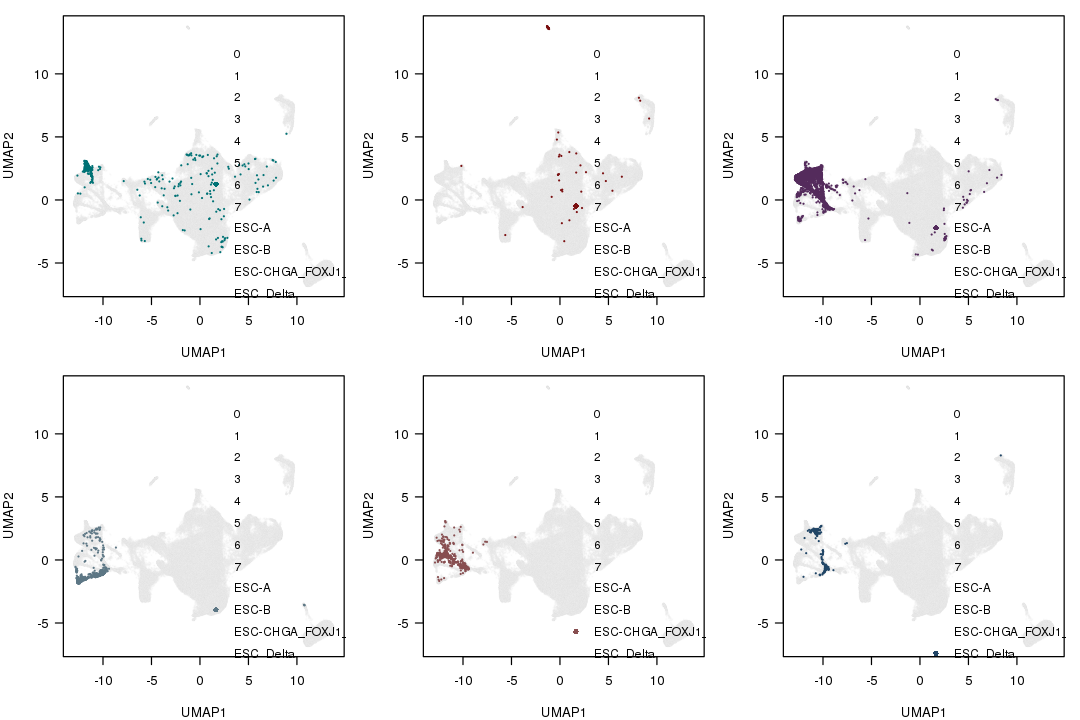

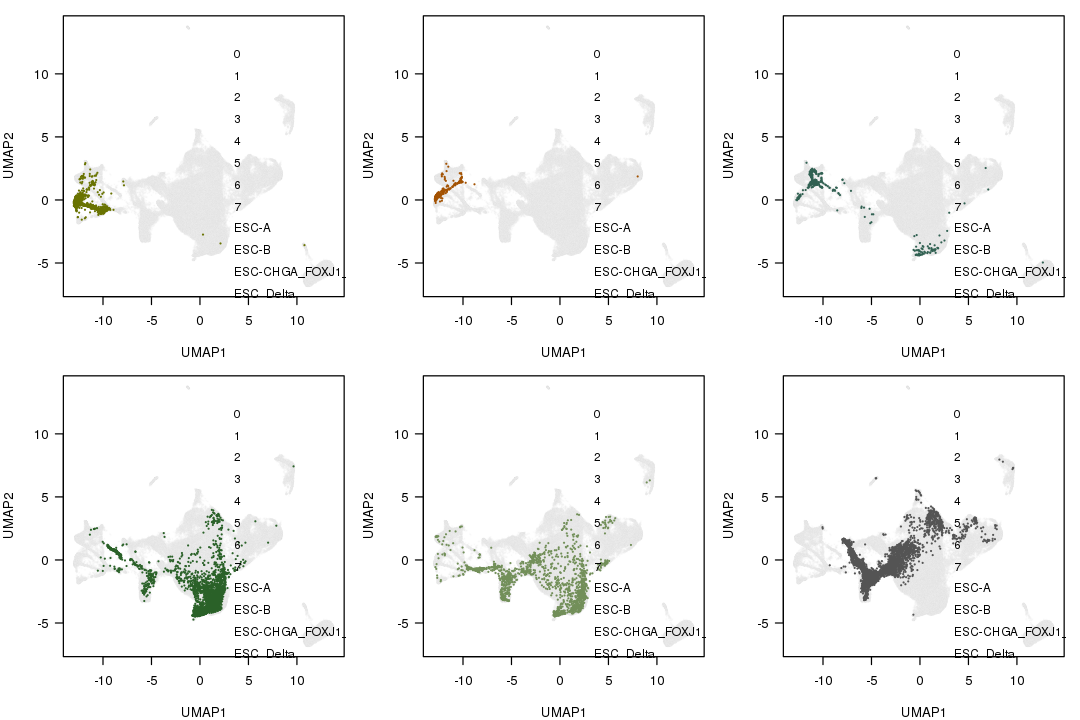

In [143]:
par(mfrow = c(2,3))
options(repr.plot.width = 9, repr.plot.height = 6)
samp.cols      = c('#016e48','#87096a',"#001678",'#8a312b','#856800','#5a4991','#007275',"#7a0f10","#542b5c","#5d7785","#874e50","#204566","#697301","#a35202","#316152","#2a6128","#728f59","#545454")
samp.cols.null = rep("#ededed00", length(samp.cols))

BreakUMAPWrapper(integrated, "new_celltype", samp.cols, samp.cols.null)

In [153]:
PlotGeneExpression <- function(obj){
    options(repr.plot.width = 5, repr.plot.height = 3)
    p <- FeaturePlot(obj, features = c("PDX1", "NKX6-1"),
                pt.size = .01, min.cutoff = 0, max.cutoff = 5, combine = FALSE)

    for(i in 1:length(p)) {

        p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 8) + NoAxes() 

    }

    cowplot::plot_grid(plotlist = p, ncol = 2)
}


Warning message:
“Could not find NKX6-1 in the default search locations, found in RNA assay instead”

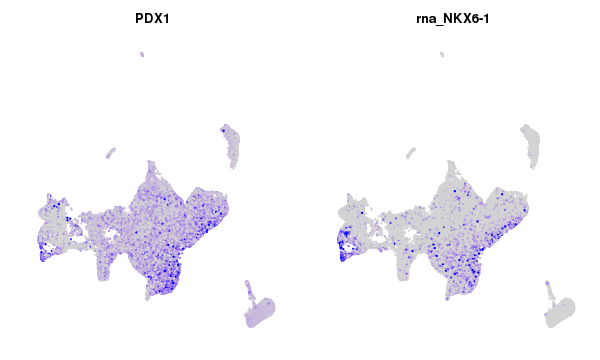

In [154]:
PlotGeneExpression(integrated)

# Correlation

In [294]:
tiss.reannotate <- tiss
Idents(object = tiss.reannotate) <- "new_celltype"

In [314]:
tiss.reannotate.subset = subset(tiss.reannotate, max.cells.per.ident = 3500, cells = colnames(x = tiss.reannotate)[sample(nrow(tiss@meta.data), 50000)])

In [315]:
tiss.reannotate
tiss.reannotate.subset

An object of class Seurat 
60358 features across 101189 samples within 2 assays 
Active assay: integrated (2000 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
60358 features across 50000 samples within 2 assays 
Active assay: integrated (2000 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [316]:
cluster.averages <- AverageExpression(tiss.reannotate.subset)

Finished averaging RNA for cluster iPSC
Finished averaging RNA for cluster iPSC-PDX1_High_NKX61_High
Finished averaging RNA for cluster iPSC-PDX1_High_NKX61_High replicating
Finished averaging RNA for cluster iPSC-PDX1_Low_NKX61_Low
Finished averaging RNA for cluster iPSC-PDX1_Moderate_NKX61_Moderate
Finished averaging RNA for cluster iPSC-Endocrine
Finished averaging RNA for cluster iPSC-Endothelial
Finished averaging RNA for cluster SC-Replicating
Finished averaging RNA for cluster SC-PDX1_progenitor
Finished averaging RNA for cluster SC-NKX6-1_progenitor
Finished averaging RNA for cluster SC-A
Finished averaging RNA for cluster SC_FEV_high_ISL_low_partial_endrocrine_enduction
Finished averaging RNA for cluster SC-NEUROG_progenitor_endocrine_induction
Finished averaging RNA for cluster SC_Delta
Finished averaging RNA for cluster SC-non-endocrine
Finished averaging RNA for cluster SC-B
Finished averaging RNA for cluster SC-EC
Finished averaging RNA for cluster SC-CHGA_FOXJ1_pos
Finish

In [317]:
# save(cluster.averages, file = "/projects/PPC/analysis/ppc_pilot/data/gene_expression/PPC_merged_Melton_annotated_byCelltypes_averages.robj")

In [645]:
exp.int = log1p(cluster.averages$integrated)
exp.int <- exp.int[is.finite(rowSums(exp.int)),]
# comp <- comp[! comp[,1] == 0, ]
# comp <- comp[! comp[,2] == 0, ]
# exp.int = log(exp.int)
# coravg = cor(exp.int)

# exp.int <- exp.int[! is.na(exp.int), ]

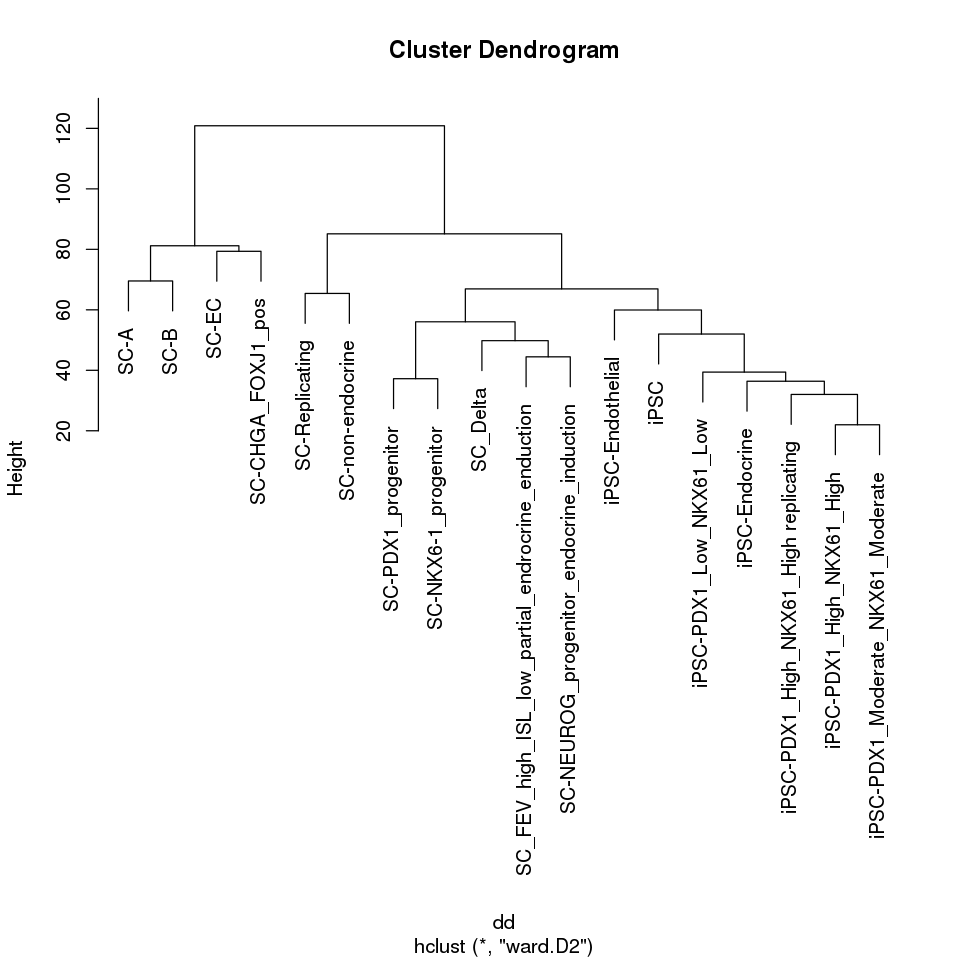

In [656]:
exp.int = log1p(cluster.averages$integrated)
# exp.int <- exp.int[is.finite(rowSums(exp.int)),]
dd <- dist(scale(t(exp.int)), method = "euclidean")
hc <- hclust(dd, method = "ward.D2")


# pdf(paste(out, "Figure_2_melton_dendogram.pdf",sep = ""), width = 8, height = 8)
options(repr.plot.width = 8, repr.plot.height = 8)
plot(hc)
# dev.off()

In [549]:
avg.iPSC.PDX1_High_NKX61_High.test <- data.frame( gene = rownames(cluster.averages$RNA), ipsc = log1p(cluster.averages$RNA[, "iPSC-PDX1_High_NKX61_High"]))
avg.iPSC.PDX1_High_NKX61_High.test[avg.iPSC.PDX1_High_NKX61_High.test$gene == "SST", ]

avg.SC.PDX1_progenitor.test        <- data.frame( gene = rownames(cluster.averages$RNA), sc = log1p(cluster.averages$RNA[, "SC-PDX1_progenitor"]))
comp = merge(avg.SC.PDX1_progenitor.test, avg.iPSC.PDX1_High_NKX61_High.test)
rownames(comp) <- comp$gene
comp$gene <- NULL
comp <- comp[is.finite(rowSums(comp)),]
# comp <- comp[! comp[,1] == 0, ]
# comp <- comp[! comp[,2] == 0, ]

,gene,ipsc
,<chr>,<dbl>
12282,SST,0.07733905


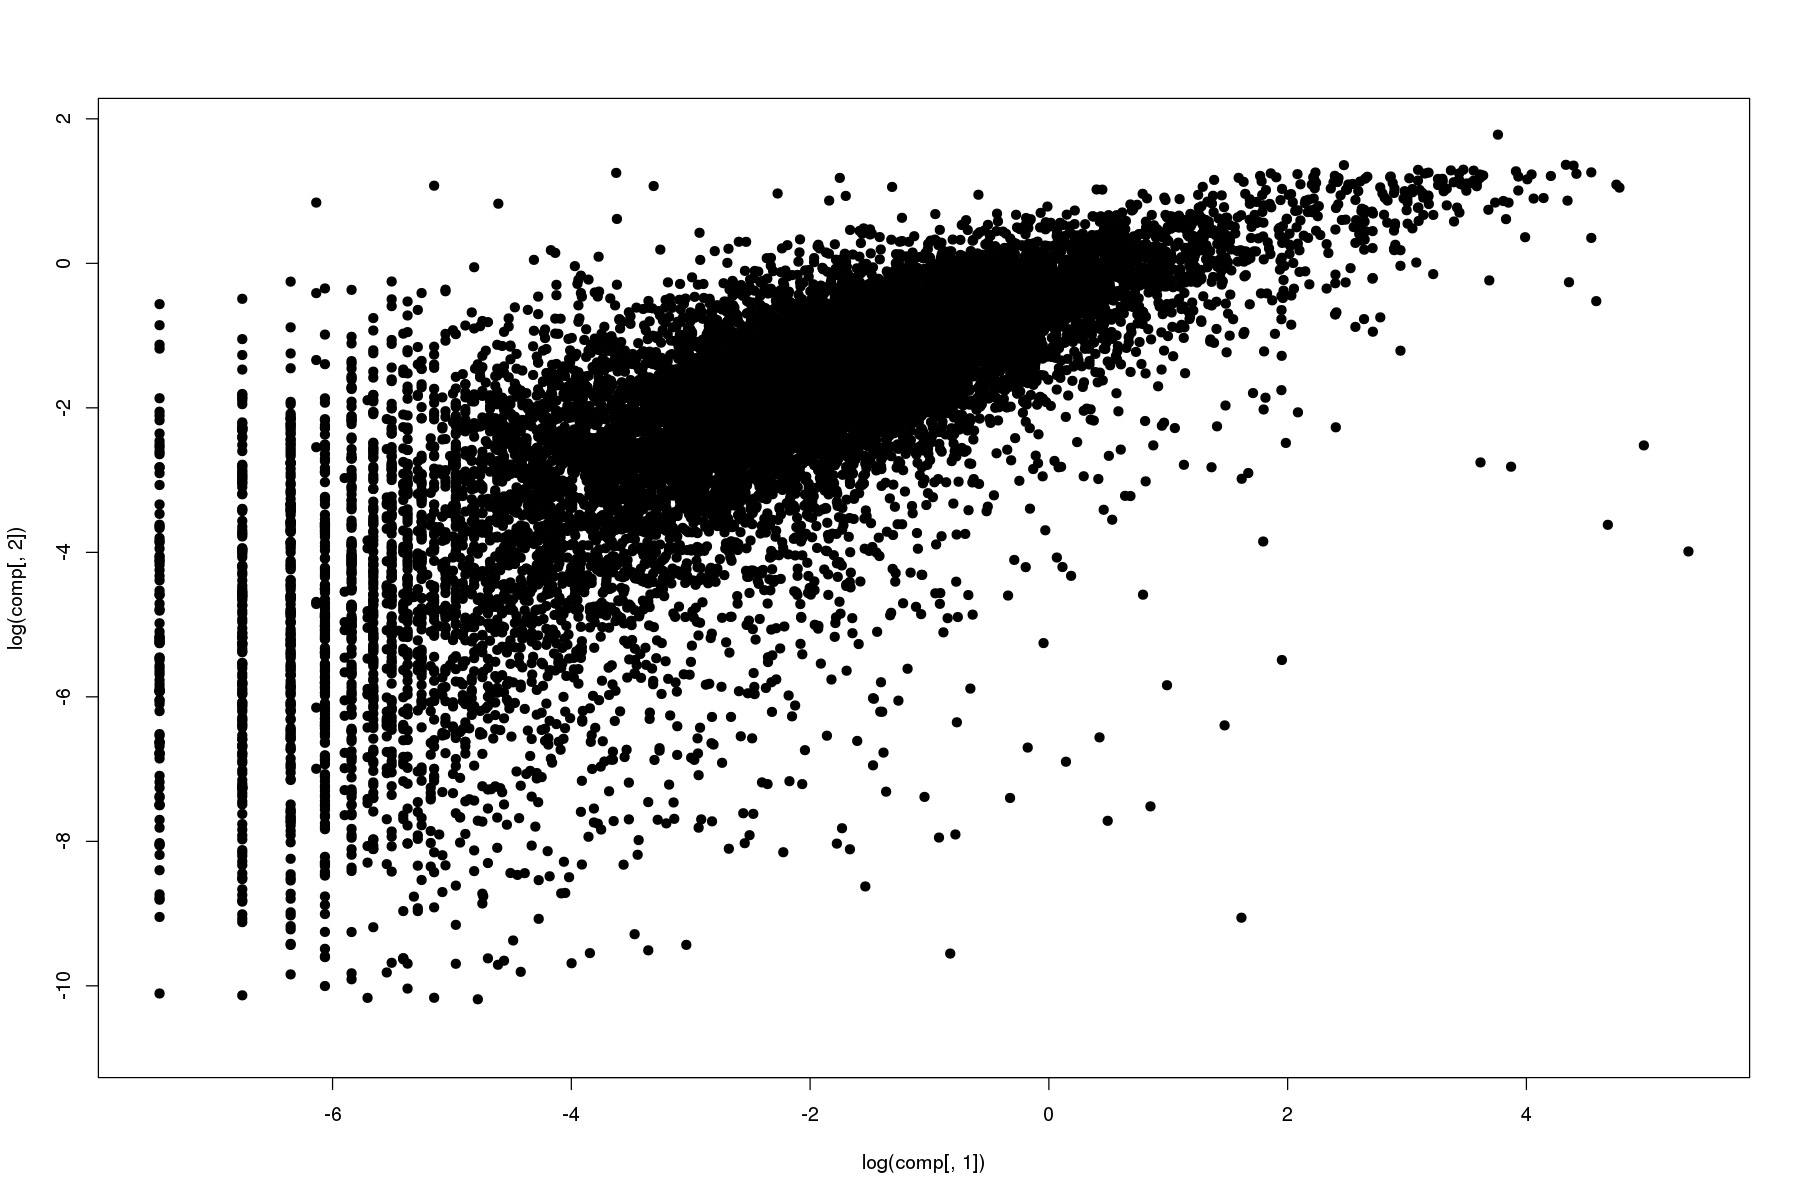

In [545]:
plot(log(comp[,1]), log(comp[,2]), pch = 19)

In [ ]:
iPSC.PDX1_High_NKX61_High <- subset(tiss.reannotate.subset, idents = "iPSC-PDX1_High_NKX61_High")
Idents(iPSC.PDX1_High_NKX61_High) <- "ipsc"
avg.iPSC.PDX1_High_NKX61_High <- log1p(AverageExpression(iPSC.PDX1_High_NKX61_High, verbose = FALSE)$RNA)
avg.iPSC.PDX1_High_NKX61_High$gene <- rownames(avg.t.cells)

# cd14.mono <- subset(immune.combined, idents = "CD14 Mono")
# Idents(cd14.mono) <- "stim"
# avg.cd14.mono <- log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA)
# avg.cd14.mono$gene <- rownames(avg.cd14.mono)

# genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
# p1 <- ggplot(avg.t.cells, aes(CTRL, STIM)) + geom_point() + ggtitle("CD4 Naive T Cells")
# p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
# p2 <- ggplot(avg.cd14.mono, aes(CTRL, STIM)) + geom_point() + ggtitle("CD14 Monocytes")
# p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
# plot_grid(p1, p2)

# Take random subset of each sample to perform pseudotime analysis

In [156]:
library(monocle3)

In [157]:
# f = "/projects/PPC/analysis/ppc_pilot/data/robjs/Frazermerged_new_seurat_SCBintegrated.robj"
# sample_name = tools::file_path_sans_ext(basename(f))
# load(f)

In [189]:
data = integrated #subset(integrated, cells = colnames(x = integrated)[sample(nrow(integrated@meta.data), 3000)])

In [190]:
expression_matrix = data@assays$RNA

In [191]:
cell_metadata = data@meta.data
cell_metadata = cell_metadata[rownames(cell_metadata) %in% colnames(expression_matrix),]
cell_metadata$cell <- rownames(cell_metadata)
gene_annotation = data.frame(row.names = rownames(expression_matrix), id = rownames(expression_matrix), gene_short_name = rownames(expression_matrix))

In [192]:
cds <- new_cell_data_set(expression_matrix[, rownames(cell_metadata)],
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)

In [193]:
## Monocles pipeline
# cds = preprocess_cds(cds, method='PCA', num_dim = 5)
# cds = reduce_dimension(cds, preprocess_method='PCA', reduction_method='UMAP')
# cds = cluster_cells(cds, reduction_method='UMAP')

## Use Seurat's data
cds@reducedDims$PCA = Embeddings(object = data[["pca"]])
cds@reducedDims$UMAP = Embeddings(object = data[["umap"]])
cds = cluster_cells(cds, reduction_method='UMAP')


In [194]:
## When you learn_graph(cds, use_partition=F) you cannot set root node to a partition > 1 (per https://github.com/cole-trapnell-lab/monocle-release/issues/280)
## set all partitions to 1 for workaround.
levels(cds@clusters$UMAP$partitions)

[1] "1" "2" "3" "4" "5"

In [195]:
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '2'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '3'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '4'] <- '1'
cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions == '5'] <- '1'

In [ ]:
cds = learn_graph(cds, use_partition=F)

In [ ]:
options(repr.plot.width =10, repr.plot.height = 5)
plot_cells(cds, 
           genes=c("PDX1", "NKX6-1"), 
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

In [ ]:
options(repr.plot.width =8, repr.plot.height = 8)

plot_cells(cds, 
           color_cells_by = "new_celltype", 
           label_cell_groups=TRUE, 
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

plot_cells(cds, 
           color_cells_by = "partition", 
           label_cell_groups=TRUE, 
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

# plot_cells(cds, 
#            color_cells_by = "RNA_snn_res.0.5", 
#            label_cell_groups=TRUE, 
#            label_leaves=TRUE,
#            label_branch_points=TRUE,
#            graph_label_size=1.5)

# options(repr.plot.width = 5, repr.plot.height = 5)
# plot_cells(cds, 
#            color_cells_by = "partition", 
#            label_cell_groups=FALSE, 
#            label_leaves=TRUE,
#            label_branch_points=TRUE,
#            graph_label_size=1.5)

In [ ]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, cell_phenotype, root_type){

    cell_ids <- which(pData(cds)[, cell_phenotype] == root_type)


    closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
    closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
    root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]

    root_pr_nodes
}


In [ ]:
get_earliest_principal_node(cds, "new_celltype", "2")

In [184]:
cds = order_cells(cds, root_pr_nodes = 'Y_169') #get_earliest_principal_node(cds, "new_celltype", "SC-CHGA_FOXJ1_pos"))


# pData(cds)$Pseudotime_updated <- max(pData(cds)$pseudotime) - pData(cds)$pseudotime



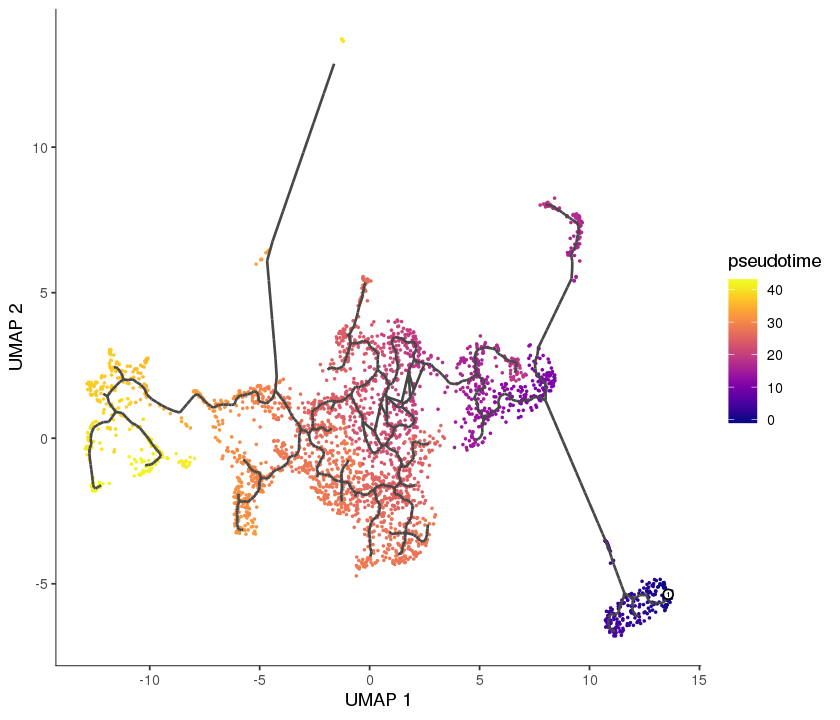

In [185]:
options(repr.plot.width =7, repr.plot.height = 6)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

In [186]:
genes = c("PDX1", "NKX6-1", "CHGA")

lineage_cds = cds[rowData(cds)$gene_short_name %in% genes,]

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

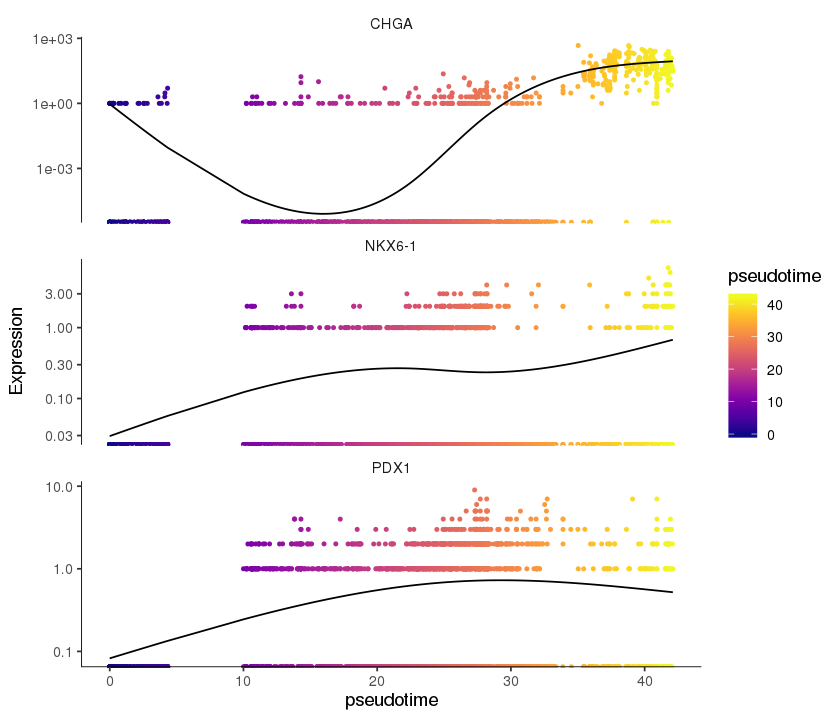

In [187]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="pseudotime")

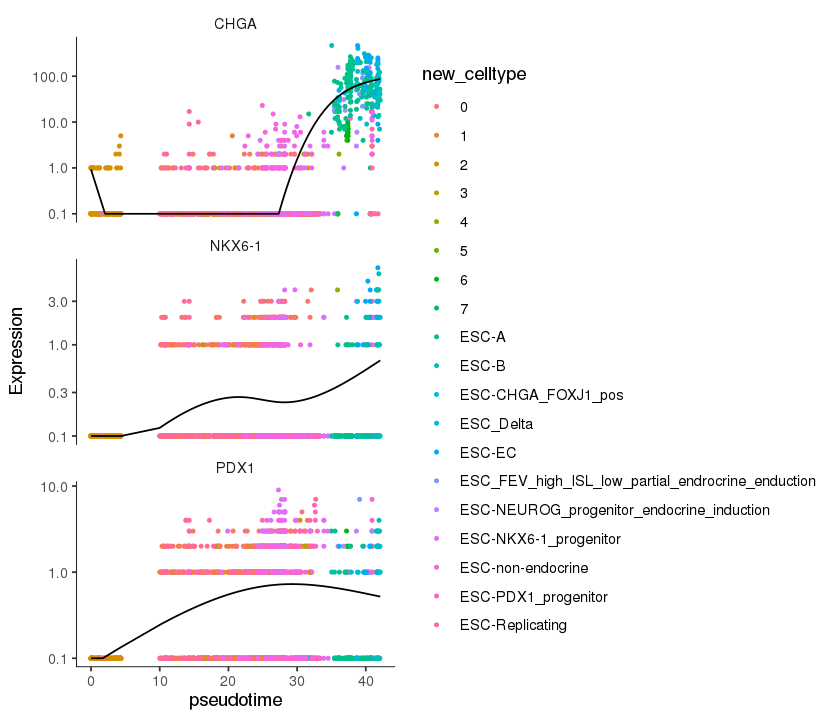

In [188]:
plot_genes_in_pseudotime(lineage_cds, 
                         color_cells_by="new_celltype",
                         min_expr=0.1)